In [5]:
import matplotlib.pyplot as plt


import math
import numpy as np

from pycalphad import Database, equilibrium, calculate, binplot
from pycalphad import variables as v
from pycalphad.plot.utils import phase_legend

In [33]:
alsi = "tdbs/AlSi-97Feu-LB.tdb"
gesi = "tdbs/GeSi-84Ole.tdb"

In [34]:
db = Database(alsi)

elements = ['AL', 'SI', 'VA']
el_cnt = 1                      # кол-во вещества на 1 моль
press = 101325                  # атмосферное давление, константа

phases = list(db.phases.keys())
phases

['LIQUID', 'FCC_A1', 'BCC_A2', 'HCP_A3', 'DIAMOND_A4']

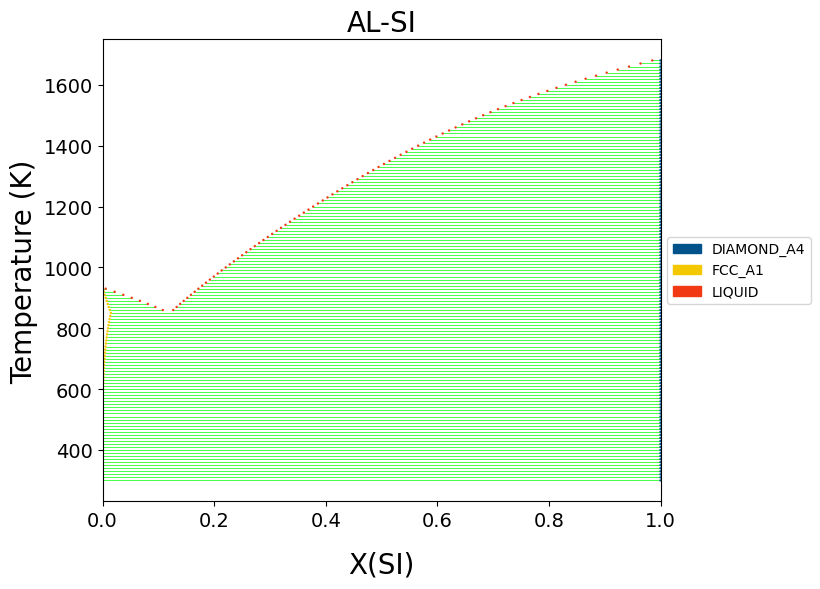

In [35]:
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

binplot(db, elements, phases, {v.X('SI'):(0,1,0.02), v.T: (200, 1800, 10), v.P:press, v.N: el_cnt}, plot_kwargs={'ax': axes})

plt.show()

In [36]:
def getGibbsEnergy(file_path, key_word, ind):
    gibbs_energy = "Not found"
    found = False
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if line.startswith(key_word):
                line_arr = line.strip().split()
                if len(line_arr) >= ind:
                    gibbs_energy = line_arr[ind]
                    found = True
            elif found:
                gibbs_energy += line
                if line[-1] == ';':
                    break
    return gibbs_energy

In [37]:
import re
import numpy as np

class functionParser:
    def __init__(self, text) -> str:
        self.text = text
        self.vals = None
        self.pows = None
        self.logs= None
    
    def powsNLogs(self):
        first_row = True
        pows = [0]      
        logs = [0]  
        for part in self.text.split('*T'):
            if first_row:
                first_row = False
                continue
            first_minus = part.find('-')
            first_plus = part.find('+')
            first_scobe = part.find(')')
            new_part = part[:max(first_minus, first_scobe, first_plus)]

            pow_text = new_part.strip('*').strip('(')
            if pow_text == "":
                pow_text = '1'
            if re.search(r'[0-9]', pow_text):
                pow_text = int(pow_text)
                logs.append(0)
            else:
                # хардкод лагорифма
                pow_text = 1
                logs.append(1)
            
            pows.append(pow_text)
        self.pows = pows
        self.logs= logs
        return pows, logs

    def values(self):
        values = []
        first_row = True
        for part in re.split(r"\*T[*]{0,2}[0-9]{0,1}(LN\(T\)){0,1}",self.text):
            if part == None or part == "LN(T)" or part.startswith('('):
                continue

            if first_row:
                oper_m = part[0] == '-'
                first_ind = 0
                # Без учета E
                if len(part.split('+')) > 1 and part[0] != '+' or len(part.split('+')) > 2:
                    if len(part.split('+')) > 2:
                        first_ind += 1
                    values.append(float(part.split('+')[first_ind]))
                    values.append(float(part.split('+')[first_ind + 1]))
                else:
                    if len(part.split('-')) > 2:
                        first_ind += 1
                    values.append(-float(part.split('-')[first_ind]) if oper_m else float(part.split('-')[first_ind]))
                    values.append(-float(part.split('-')[first_ind + 1]))

                first_row = False
            else:
                values.append(float(part))
        self.vals = values
        return values

    def stringF(self):
        if self.vals == None:
            self.values()
        if self.pows == None or self.logs == None:
            self.powsNLogs()
        output = ""
        for (v, p, l) in zip(self.vals, self.pows, self.logs):
            if v >= 0:
                output += "+"
            if l > 0:
                output += f"{v}*T^{p}*LN(T) "
            else:
                output += f"{v}*T^{p} "
        return output
        

    def functionAt(self, i):
        if self.vals == None:
            self.values()
        if self.pows == None or self.logs == None:
            self.powsNLogs()
        answer = 0
        for (v, p, l) in zip(self.vals, self.pows, self.logs):
            if l > 0:
                answer += v * i**p * np.log(i)
            else:
                answer += v * i**p 
        return answer
        
        

In [38]:
parser = functionParser(getGibbsEnergy(alsi, "FUNCTION GHSERAL", 3))
print(parser.stringF())
print(parser.functionAt(1))


-7976.15*T^0 +137.093038*T^1 -24.3671976*T^1*LN(T) -0.001884662*T^2 -8.77664e-07*T^3 +74092.0*T^-1 
66252.94115246033


Функция: $-7976.15+137.093038*T-24.3671976*T*LN(T)-0.001884662*T**2-8.77664E-07*T**3+74092*T**(-1)$;

-7976.15*T^0 +137.093038*T^1 -24.3671976*T^1*LN(T) -0.001884662*T^2 -8.77664e-07*T^3 +74092.0*T^-1 
-9486.153*T^0 +165.635573*T^1 -29.5337682*T^1*LN(T) +0.005568297*T^2 -1.513694e-06*T^3 +163298.0*T^-1 


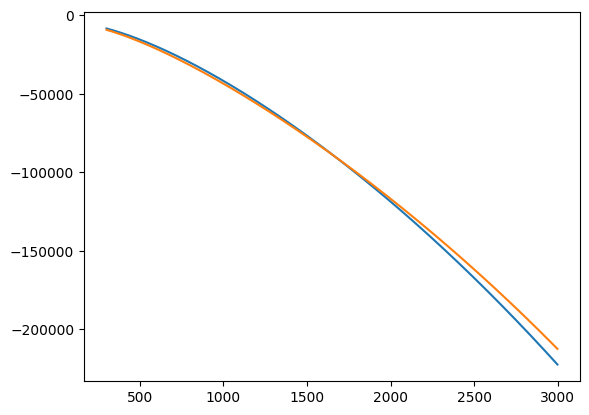

In [39]:
gibbs = []
parser = functionParser(getGibbsEnergy(alsi, "FUNCTION GHSERAL", 3))
print(parser.stringF())

range_T = range(300, 3000)
for T in range_T:
    gibbs.append(parser.functionAt(T))


plt.plot(range_T, gibbs)
gibbs = []
parser = functionParser(getGibbsEnergy(gesi, "FUNCTION GHSERGE", 3))
print(parser.stringF())

for T in range_T:
    gibbs.append(parser.functionAt(T))
plt.plot(range_T, gibbs)
plt.show()

PYCALPHAD calculate - из него нельзя найти структуру коэффициентов энергии Гиббса

In [ ]:
def calculate(dbf, comps, phases, mode=None, output='GM', fake_points=False, broadcast=True, parameters=None, to_xarray=True, phase_records=None, **kwargs):
    """
    Sample the property surface of 'output' containing the specified
    components and phases. Model parameters are taken from 'dbf' and any
    state variables (T, P, etc.) can be specified as keyword arguments.

    Parameters
    ----------
    dbf : Database
        Thermodynamic database containing the relevant parameters.
    comps : str or sequence
        Names of components to consider in the calculation.
    phases : str or sequence
        Names of phases to consider in the calculation.
    mode : string, optional
        See 'make_callable' docstring for details.
    output : string, optional
        Model attribute to sample.
    fake_points : bool, optional (Default: False)
        If True, the first few points of the output surface will be fictitious
        points used to define an equilibrium hyperplane guaranteed to be above
        all the other points. This is used for convex hull computations.
    broadcast : bool, optional
        If True, broadcast given state variable lists against each other to create a grid.
        If False, assume state variables are given as equal-length lists.
    points : ndarray or a dict of phase names to ndarray, optional
        Columns of ndarrays must be internal degrees of freedom (site fractions), sorted.
        If this is not specified, points will be generated automatically.
    pdens : int, a dict of phase names to int, or a seq of both, optional
        Number of points to sample per degree of freedom.
        Default: 2000; Default when called from equilibrium(): 500
    model : Model, a dict of phase names to Model, or a seq of both, optional
        Model class to use for each phase.
    sampler : callable, a dict of phase names to callable, or a seq of both, optional
        Function to sample phase constitution space.
        Must have same signature as 'pycalphad.core.utils.point_sample'
    grid_points : bool, a dict of phase names to bool, or a seq of both, optional (Default: True)
        Whether to add evenly spaced points between end-members.
        The density of points is determined by 'pdens'
    parameters : dict, optional
        Maps SymEngine Symbol to numbers, for overriding the values of parameters in the Database.
    phase_records : Optional[Mapping[str, PhaseRecord]]
        Mapping of phase names to PhaseRecord objects. Must include all active phases.
        The `model` argument must be a mapping of phase names to instances of Model
        objects. Callers must take care that the PhaseRecord objects were created with
        the same `output` as passed to `calculate`.

    Returns
    -------
    Dataset of the sampled attribute as a function of state variables

    Examples
    --------
    None yet.
    """
    # Here we check for any keyword arguments that are special, i.e.,
    # there may be keyword arguments that aren't state variables
    pdens_dict = unpack_kwarg(kwargs.pop('pdens', 2000), default_arg=2000)
    points_dict = unpack_kwarg(kwargs.pop('points', None), default_arg=None)
    callables = kwargs.pop('callables', {})
    sampler_dict = unpack_kwarg(kwargs.pop('sampler', None), default_arg=None)
    fixedgrid_dict = unpack_kwarg(kwargs.pop('grid_points', True), default_arg=True)
    model = kwargs.pop('model', None)
    parameters = parameters or dict()
    if isinstance(parameters, dict):
        parameters = OrderedDict(sorted(parameters.items(), key=str))
    if isinstance(phases, str):
        phases = [phases]
    if isinstance(comps, (str, v.Species)):
        comps = [comps]
    comps = sorted(unpack_components(dbf, comps))
    if points_dict is None and broadcast is False:
        raise ValueError('The \'points\' keyword argument must be specified if broadcast=False is also given.')
    nonvacant_components = [x for x in sorted(comps) if x.number_of_atoms > 0]
    nonvacant_elements = get_pure_elements(dbf, comps)

    all_phase_data = []
    largest_energy = 1e10

    # Consider only the active phases
    list_of_possible_phases = filter_phases(dbf, comps)
    if len(list_of_possible_phases) == 0:
        raise ConditionError('There are no phases in the Database that can be active with components {0}'.format(comps))
    active_phases = filter_phases(dbf, comps, phases)
    if len(active_phases) == 0:
        raise ConditionError('None of the passed phases ({0}) are active. List of possible phases: {1}.'.format(phases, list_of_possible_phases))

    if isinstance(output, (list, tuple, set)):
        raise NotImplementedError('Only one property can be specified in calculate() at a time')
    output = output if output is not None else 'GM'

    # Implicitly add 'N' state variable as a string to keyword arguements if it's not passed
    if kwargs.get('N') is None:
        kwargs['N'] = 1
    if np.any(np.array(kwargs['N']) != 1):
        raise ConditionError('N!=1 is not yet supported, got N={}'.format(kwargs['N']))

    # TODO: conditions dict of StateVariable instances should become part of the calculate API
    statevar_strings = [sv for sv in kwargs.keys() if getattr(v, sv) is not None]
    # If we don't do this, sympy will get confused during substitution
    statevar_dict = dict((v.StateVariable(key), unpack_condition(value)) for key, value in kwargs.items() if key in statevar_strings)
    # Sort after default state variable check to fix gh-116
    statevar_dict = OrderedDict(sorted(statevar_dict.items(), key=lambda x: str(x[0])))
    str_statevar_dict = OrderedDict((str(key), unpack_condition(value)) for (key, value) in statevar_dict.items())

    # Build phase records if they weren't passed
    if phase_records is None:
        models = instantiate_models(dbf, comps, active_phases, model=model, parameters=parameters)
        phase_records = build_phase_records(dbf, comps, active_phases, statevar_dict,
                                            models=models, parameters=parameters,
                                            output=output, callables=callables,
                                            build_gradients=False, build_hessians=False,
                                            verbose=kwargs.pop('verbose', False))
    else:
        # phase_records were provided, instantiated models must also be provided by the caller
        models = model
        if not isinstance(models, Mapping):
            raise ValueError("A dictionary of instantiated models must be passed to `equilibrium` with the `model` argument if the `phase_records` argument is used.")
        active_phases_without_models = [name for name in active_phases if not isinstance(models.get(name), Model)]
        active_phases_without_phase_records = [name for name in active_phases if not isinstance(phase_records.get(name), PhaseRecord)]
        if len(active_phases_without_phase_records) > 0:
            raise ValueError(f"phase_records must contain a PhaseRecord instance for every active phase. Missing PhaseRecord objects for {sorted(active_phases_without_phase_records)}")
        if len(active_phases_without_models) > 0:
            raise ValueError(f"model must contain a Model instance for every active phase. Missing Model objects for {sorted(active_phases_without_models)}")

    maximum_internal_dof = max(len(models[phase_name].site_fractions) for phase_name in active_phases)
    for phase_name in sorted(active_phases):
        mod = models[phase_name]
        phase_record = phase_records[phase_name]
        points = points_dict[phase_name]
        if points is None:
            points = _sample_phase_constitution(mod, sampler_dict[phase_name] or point_sample,
                                                fixedgrid_dict[phase_name], pdens_dict[phase_name])
        points = np.atleast_2d(points)

        fp = fake_points and (phase_name == sorted(active_phases)[0])
        phase_ds = _compute_phase_values(nonvacant_components, str_statevar_dict,
                                         points, phase_record, output,
                                         maximum_internal_dof, broadcast=broadcast, parameters=parameters,
                                         largest_energy=float(largest_energy), fake_points=fp)
        all_phase_data.append(phase_ds)

    fp_offset = len(nonvacant_elements) if fake_points else 0
    running_total = [fp_offset] + list(np.cumsum([phase_ds['X'].shape[-2] for phase_ds in all_phase_data]))
    islice_by_phase = {phase_name: slice(running_total[phase_idx], running_total[phase_idx+1], None)
                       for phase_idx, phase_name in enumerate(sorted(active_phases))}
    # speedup for single-phase case (found by profiling)
    if len(all_phase_data) > 1:
        concatenated_coords = all_phase_data[0].coords

        data_vars = all_phase_data[0].data_vars
        concatenated_data_vars = {}
        for var in data_vars.keys():
            data_coords = data_vars[var][0]
            points_idx = data_coords.index('points')  # concatenation axis
            arrs = []
            for phase_data in all_phase_data:
                arrs.append(getattr(phase_data, var))
            concat_data = np.concatenate(arrs, axis=points_idx)
            concatenated_data_vars[var] = (data_coords, concat_data)
        final_ds = LightDataset(data_vars=concatenated_data_vars, coords=concatenated_coords)
    else:
        final_ds = all_phase_data[0]
    final_ds.attrs['phase_indices'] = islice_by_phase
    if to_xarray:
        return final_ds.get_dataset()
    else:
        return final_ds
